In [1]:
import torch #for building nn and manipulate tensors
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random #for shuffling values 
import pandas as pd 
from torcheval.metrics.text import Perplexity
import torchmetrics #calculate evaluation metrics 
%matplotlib inline

C:\Users\aleja\AppData\Local\Temp\ipykernel_16228\2603796560.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Read words in our SPANISH dataset 
names= open('corpus/raw_name_list.txt', 'r', encoding='utf-8').read().lower().splitlines()
print(f'Number of names in dataset:{len(names)}')

Number of names in dataset:334


In [3]:
#Building vocabulary 
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #add dot at position 0 for building block size 
itos = {i:s for s,i in stoi.items()}
len_vocab= len(itos)
print(itos)
print(f'Lenght of vocabulary: {len_vocab}')

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'x', 25: 'y', 26: 'z', 27: 'ñ', 0: '.'}
Lenght of vocabulary: 28


In [4]:
# Build the dataset

block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], [] #X are the values, Y are the labels 
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(names) #shuffles names in dataset 

#Train/validation/test 
n1 = int(0.8*len(names)) 
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1]) #training split. 80%. 
Xdev, Ydev = build_dataset(names[n1:n2]) #validation split. 10% 
Xte, Yte = build_dataset(names[n2:]) #test split. 10%

torch.Size([2044, 4]) torch.Size([2044])
torch.Size([258, 4]) torch.Size([258])
torch.Size([272, 4]) torch.Size([272])


In [5]:
#Shape of training split (X and Y)
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([2044, 4]), torch.int64, torch.Size([2044]), torch.int64)

In [6]:
#Setting number of neurons
neurons= 250

In [7]:
#Building of NN 
g = torch.Generator().manual_seed(2147483647) # for reproducibility
dim_embedding = 10 #dimensions of embedding 

C = torch.randn((len_vocab, dim_embedding), generator=g) #Look-up table C
W1 = torch.randn((dim_embedding*block_size, neurons), generator=g) #hidden layer. Random initialized weights. 6 because 3x2. 100 variable.
b1 = torch.randn(neurons, generator=g) #bias 
W2 = torch.randn((neurons, len_vocab), generator=g) #softmax function (outputs)
b2 = torch.randn(len_vocab, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True #states that gradients have to be computed for each parameter 

In [8]:
# Number of parameters in total
sum(p.nelement() for p in parameters) 

17558

In [9]:
#Keeping track of learning rate and loss 
lri= []
lossi=[]
stepi=[]
loss_val = []

for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (60,))
  
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, block_size*dim_embedding) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  emb_val = C[Xdev]
  h = torch.tanh(emb_val.view(-1, block_size*dim_embedding) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ydev)
  loss_val.append(loss.log10().item())

#print(loss.item())

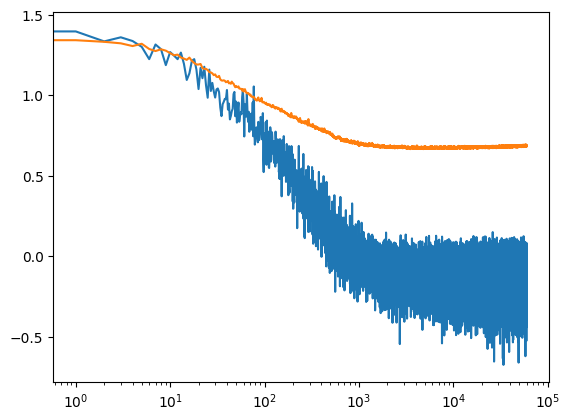

In [10]:
#Plotting loss of traning and validation curves 
plt.semilogx(stepi, lossi)
plt.semilogx(stepi, loss_val)
plt.show()

iters_opt = torch.argmin(torch.tensor(loss_val))

In [11]:
#NN with optimized number of iterations 

C = torch.randn((len_vocab, dim_embedding), generator=g) 
W1 = torch.randn((dim_embedding*block_size, neurons), generator=g) #hidden layer. Random initialized weights. 6 because 3x2. 100 variable.
b1 = torch.randn(neurons, generator=g) #bias 
W2 = torch.randn((neurons, len_vocab), generator=g) #softmax function (outputs)
b2 = torch.randn(len_vocab, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

for i in range(iters_opt):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (60,))
  
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, dim_embedding*block_size) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

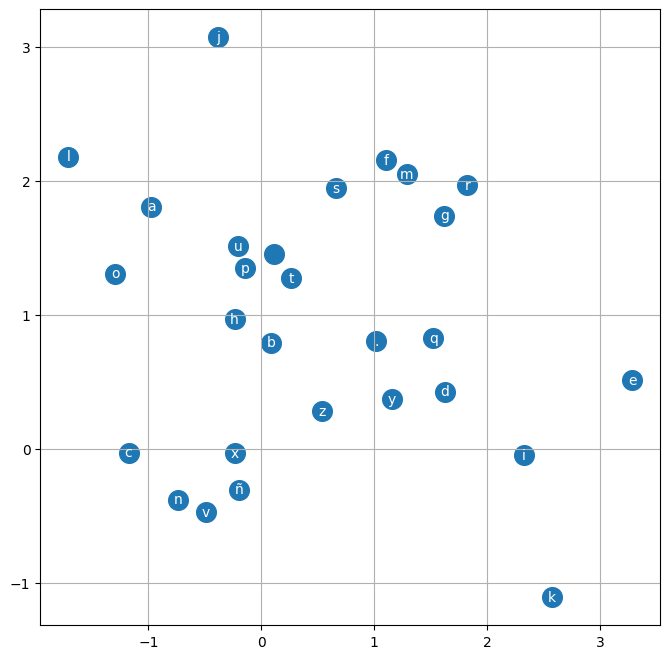

In [12]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [13]:
#Testing 
emb_tes = C[Xte] #([272, 4, 10])
h = torch.tanh(emb_tes.view(-1, block_size*dim_embedding) @ W1 + b1) # ([272, 250])
logits = h @ W2 + b2 #([272, 28])


#Cross-entropy 
import torch
loss = F.cross_entropy(logits, Yte)
print(f'Loss of our dataset:{loss.item()}')

#Perplexity 
# Reshape logits to add a dummy dimension for seq_len
logits = logits.unsqueeze(1)  # Shape will become [272, 1, 28]

# Calculate perplexity
perplexity = torch.exp(loss)
print(f"Perplexity: {perplexity.item()}")

Loss of our dataset:3.711229085922241
Perplexity: 40.904048919677734


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147048347 + 10)
generated_names_list=[]
for _ in range(200):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    generated_names= ''.join(itos[i] for i in out)
    generated_names_list.append(generated_names)
    print(generated_names)
  

marco.
maria dolorena.
anmal.
margarita.
daniel.
emilia.
rocio.
omar.
jose ignacio.
manuela.
amparo.
inmaculada.
mar.
aitor.
fatima.
hectoria.
hugo.
sofia.
celia.
samuel.
iiei.
pilar.
maria pilar.
maria nieves.
alejandrea.
eugenia.
marco.
encarnacio.
inmaculada.
ignacio.
catalina.
lucas.
antonia.
samuel.
concepcion.
sebastian.
esinikcamnnclxnarrda.
teresa.
maria mercedes.
xavier.
anmal.
alexander.
monica.
sandra.
ricaela.
ignacio.
lucas.
domingo.
marco.
encarnacio.
miriam.
marcos.
esinenando.
mercedes.
josep.
lucas.
maria cristina.
elen.
maria.
maria antonia.
beatriz.
alex.
monica.
eva.
nerea.
veronica.
adriana.
ismael.
margarita.
veronica.
maria carmen.
mar.
mariano.
sonia.
ana.
carmobep.
miguel.
calonanvrxdaanyoflaado.
santiago.
cristin.
valeria.
gema.
juan fria.
encarnacio.
encarnacio.
eugenio.
patriseñcolmlel.
martina.
ana.
laura.
fernando.
gonzalo.
jose angeles.
gonzalo.
omar.
vicente.
jordi.
david.
diana.
eugenio.
aitor.
albafaqin.
laura.
miriam.
sara.
maria.
ramon.
emilia.
eugen

In [15]:
#Cleans unwanted characters (i.e. '.')
def output_cleaning(list_of_names):
    final= []
    for i in list_of_names:
        if i.endswith('.'): 
            name_only= i[:-1]  # deletes final '.'
            final.append(name_only)
        else:
            final.append(i)  # appends original name 
    return final

In [16]:
#Original names only 
generated_names_list= output_cleaning(generated_names_list)
original_names= [n for n in generated_names_list if n not in names]
print(f'Number of original names:{len(original_names)}')
print(original_names)


Number of original names:37
['maria dolorena', 'anmal', 'hectoria', 'iiei', 'alejandrea', 'encarnacio', 'esinikcamnnclxnarrda', 'anmal', 'ricaela', 'encarnacio', 'esinenando', 'elen', 'carmobep', 'calonanvrxdaanyoflaado', 'cristin', 'juan fria', 'encarnacio', 'encarnacio', 'patriseñcolmlel', 'jose angeles', 'albafaqin', 'mirioueba', 'ana inirg', 'rosa maria pilar', 'patriz', 'elen', 'maria dolorenartina', 'maria ciptoc', 'ana isabeltoares', 'juanamadl', 'iiei', 'maria jose ramon', 'inmacuicnlercuiql', 'maria elen', 'natalina', 'maria antpanza', 'maria dolorena']


In [17]:
#For human-evaluation. Uncomment if you want to generate a new list.

dict= {"names": original_names}  
df= pd.DataFrame(dict) # opens csv with names
df.to_csv('human_evaluation/generated_names_esp.csv')


In [3]:
#Human-evaluation results 

review= pd.read_csv('human_evaluation/generated_names_esp_reviewed.csv') #read csv with reviewed data
acceptable_names= [i[1] for i in review.values if i[2]==1] #takes all accepted names, labelled with 1.

print(acceptable_names)

print('Rate of acceptable names:', len(acceptable_names) / len(review))

['encarnacio', 'ricaela', 'encarnacio', 'elen', 'cristin', 'juan fria', 'encarnacio', 'encarnacio', 'jose angeles', 'rosa maria pilar', 'patriz', 'elen', 'maria elen', 'natalina']
Rate of acceptable names: 0.3783783783783784
